In [69]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
Brazil_map = mpimg.imread("//home/allan/Documentos/IAA/Repositórios/Computação Natural/trip.png")



In [70]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

import numpy as np
import random



class AntColonySolver:
    def __init__(self,
                 cost_fn:                 Callable[[Any,Any], Union[float,int]],                         
                 
                 time=0,                  # run for a fixed amount of time
                 min_time=0,              # minimum runtime
                 timeout=0,               # maximum time in seconds to run for
                 stop_factor=2,           # how many times to redouble effort after new new best path
                 min_round_trips=10,      # minimum number of round trips before stopping
                 max_round_trips=0,       # maximum number of round trips before stopping                 
                 min_ants=0,              # Total number of ants to use
                 max_ants=0,              # Total number of ants to use
                 
                 ant_count=64,            # this is the bottom of the near-optimal range for numpy performance
                 ant_speed=1,             # how many steps do ants travel per epoch

                 distance_power=1.25,        # power to which distance affects pheromones                 
                 pheromone_power=5,    # power to which differences in pheromones are noticed
                 decay_power=0,           # how fast do pheromones decay
                 reward_power=0,          # relative pheromone reward based on best_path_length/path_length 
                 best_path_smell=2,       # queen multiplier for pheromones upon finding a new best path                  
                 start_smell=0,           # amount of starting pheromones [0 defaults to `10**self.distance_power`]

                 verbose=False,

    ):
        assert callable(cost_fn)        
        self.cost_fn         = cost_fn
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)
    
        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)
        
        self.distance_power  = float(distance_power)     
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)
        
        self.verbose         = int(verbose)
        self._initalized     = False
        
        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        ### Cache of distances between nodes
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Cache of distance costs between nodes - division in a tight loop is expensive
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### This stores the pheromone trail that slowly builds up
        self.pheromones = {
            source: {
                # Encourage the ants to start exploring in all directions and furthest nodes
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }
        
        ### Sanitise input parameters
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))
        
        ### Heuristic Exports
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True        


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ### Here come the ants!
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1

            ### Vectorized walking of ants
            # Small optimization here, testing against `> self.ant_speed` rather than `> 0` 
            #       avoids computing ants_arriving in the main part of this tight loop
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue  # skip termination checks until the next ant arrives
            
            ### Vectorized checking of ants arriving
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### ant has arrived at next_node
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )

                ### ant has returned home to the colony
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### We have found a new best path - inform the Queen
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })

                    ### leave pheromone trail
                    # doing this only after ants arrive home improves initial exploration
                    #  * self.round_trips has the effect of decaying old pheromone trails
                    # ** self.reward_power = -3 has the effect of encouraging ants to explore longer routes
                    #                           in combination with doubling pheromone for best_path
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Queen orders to double the number of ants following this new best path                            
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell


                    ### reset ant
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1


            ### Do we terminate?
            
            # Always wait for at least 1 solutions (note: 2+ solutions are not guaranteed)
            if not len(best_epochs): continue 
            
            # Timer takes priority over other constraints
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break
            
            # First epoch only has start smell - question: how many epochs are required for a reasonable result?
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue        
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break

            # This factor is most closely tied to computational power                
            if self.min_ants and self.ants_used <  self.min_ants: continue        
            if self.max_ants and self.ants_used >= self.max_ants: break            
            
            # Lets keep redoubling our efforts until we can't find anything more
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break
                                
            # Nothing else is stopping us: Queen orders the ants to continue!      
            if True: continue
            
            
            
        ### We have (hopefully) found a near-optimal path, report back to the Queen
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path


    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        # Pick a random path in proportion to the weight of the pheromone
        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node
            
        
def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }
        
    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    path_cost = path_distance(result)
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | "
          .format(len(cities), path_distance(cities), path_cost, (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    # Retornar os dados adicionais
    return result, solver.ants_used, solver.epochs_used, path_cost

In [71]:
def show_cities(path, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]    
    plt.imshow(Brazil_map)    
    for x0, y0 in path:
        plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point        
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

    
def show_path(path, starting_city=None, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    
    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    #_, (x0, y0) = starting_city
    (x0, y0) = starting_city
    plt.imshow(Brazil_map)
    #plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    
    
def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])
    
    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)        
    plt.title(" + ".join(reversed(terms)))

def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               # if xy1 == ("Name", (x,y))
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())            # if path == {"Name": (x,y)}
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]   # if path == ("Name", (x,y))
    return int(sum(
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]                                   # include cost of return journey
    ))

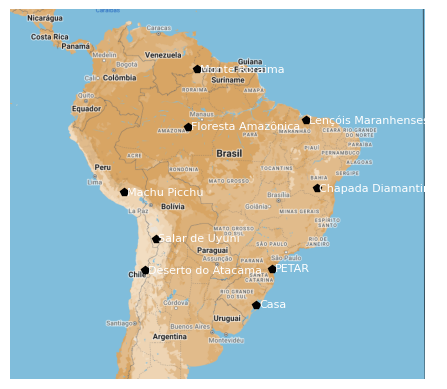

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Carregar a imagem do mapa
map_image = mpimg.imread('/home/allan/Documentos/IAA/Repositórios/Computação Natural/trip.png')
image_height, image_width = map_image.shape[:2]

# Definir os limites geográficos
min_latitude = -41.0  # Ajuste conforme o seu mapa
max_latitude = 14.0
min_longitude = -91.0
max_longitude = -24.0

# Função para converter coordenadas
def latlon_to_pixel(latitude, longitude, image_width, image_height,
                    min_latitude, max_latitude, min_longitude, max_longitude):
    x = (longitude - min_longitude) / (max_longitude - min_longitude) * image_width
    y = image_height - ((latitude - min_latitude) / (max_latitude - min_latitude) * image_height)
    return x, y

# Seus locais com latitude e longitude
places = {
    "Machu Picchu": (-13.1631, -72.5450),
    "Deserto do Atacama": (-24.7859, -69.1350),
    "Floresta Amazônica": (-3.4653, -62.2159),  # Ponto central da Amazônia
    "Salar de Uyuni": (-20.1338, -67.4891),
    "Monte Roraima": (5.1427, -60.7640),
    "Lençóis Maranhenses": (-2.4825, -43.1235),
    "Chapada Diamantina": (-12.5928, -41.4693),
    "PETAR": (-24.5300, -48.6860),  # Parque Estadual Turístico do Alto Ribeira
    "Casa": (-29.91755, -51.20215),
}
# Converter para coordenadas de imagem
image_places = {}
for place, (latitude, longitude) in places.items():
    x, y = latlon_to_pixel(latitude, longitude, image_width, image_height,
                           min_latitude, max_latitude, min_longitude, max_longitude)
    image_places[place] = (x, y)

# Plotar para verificar
plt.imshow(map_image)
for place, (x, y) in image_places.items():
    plt.plot(x, y, 'kp') 
    plt.text(x + 5, y + 5, place, color='white', fontsize=8)
plt.axis('off')
plt.show()

# Preparar os dados para o algoritmo
places_list = list(image_places.items())



In [81]:
start_distance_power = 0.00001
num_iterations = 7
distance_powers = [start_distance_power * (10 ** i) for i in range(num_iterations)]


In [82]:
# Listas para armazenar os resultados
ants_list = []
epochs_list = []
path_cost_list = []

for dp in distance_powers:
    print(f"\nExecutando com distance_power = {dp}")
    result, ants_used, epochs_used, path_cost = AntColonyRunner(
        places_list,
        distance_power=dp,
        verbose=False,
        plot=False
    )
    ants_list.append(ants_used)
    epochs_list.append(epochs_used)
    path_cost_list.append(path_cost)



Executando com distance_power = 1e-05
N=9   |  1838 -> 1312 |    0s | ants:   552 | trips:   10 | distance_power=1e-05

Executando com distance_power = 0.0001
N=9   |  1838 -> 1580 |    0s | ants:   569 | trips:   10 | distance_power=0.0001

Executando com distance_power = 0.001
N=9   |  1838 -> 1312 |    0s | ants:   543 | trips:   10 | distance_power=0.001

Executando com distance_power = 0.01
N=9   |  1838 -> 1274 |    0s | ants:   568 | trips:   10 | distance_power=0.01

Executando com distance_power = 0.1
N=9   |  1838 -> 1312 |    0s | ants:   568 | trips:   10 | distance_power=0.1

Executando com distance_power = 1.0
N=9   |  1838 -> 1274 |    0s | ants:   573 | trips:   10 | distance_power=1.0

Executando com distance_power = 10.0
N=9   |  1838 -> 1222 |    0s | ants:   581 | trips:   10 | distance_power=10.0

Executando com distance_power = 100.00000000000001


OverflowError: (34, 'Numerical result out of range')

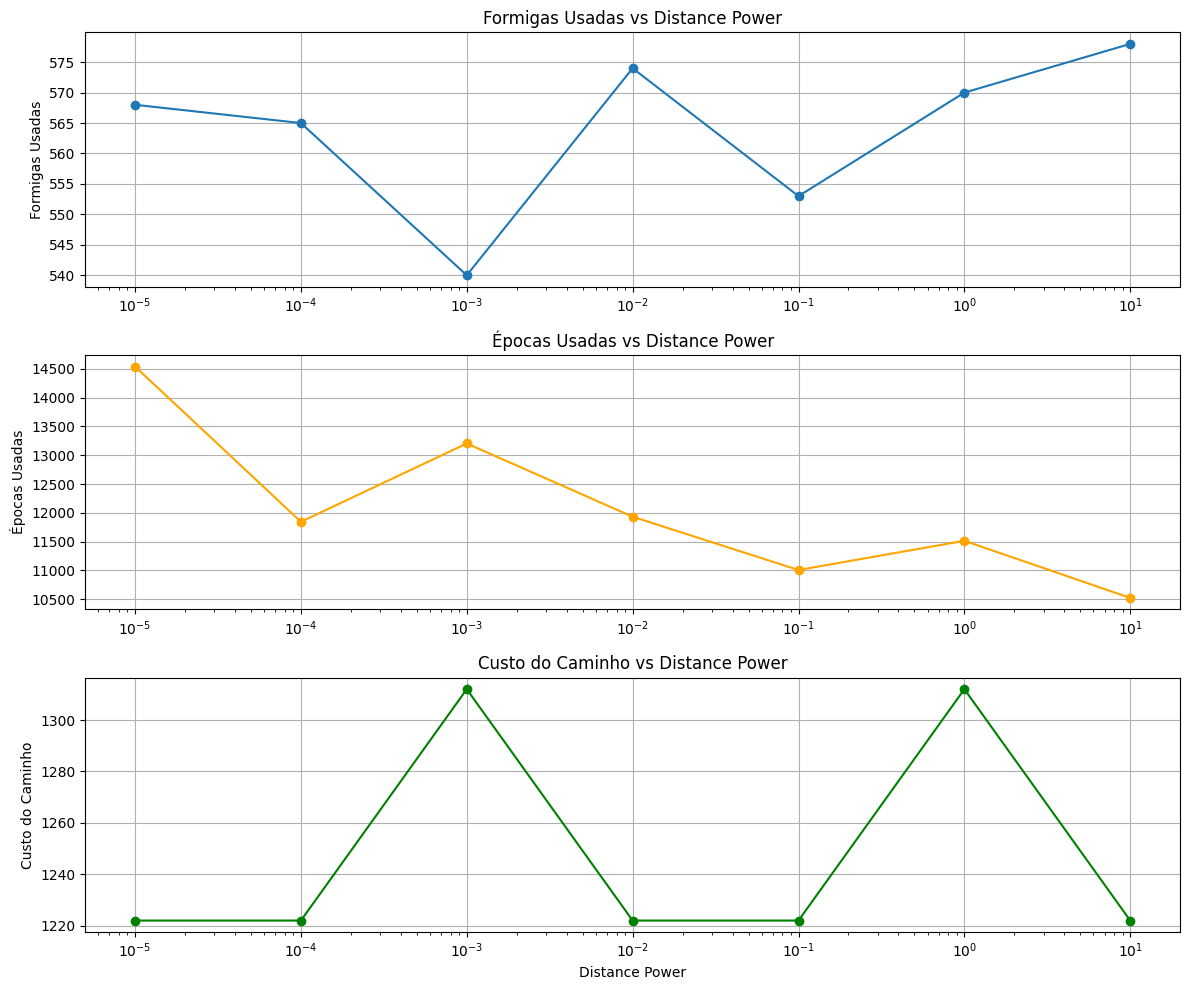

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Plotar o número de formigas usadas
plt.subplot(3, 1, 1)
plt.plot(distance_powers, ants_list, marker='o')
plt.xscale('log')
plt.ylabel('Formigas Usadas')
plt.title('Formigas Usadas vs Distance Power')
plt.grid(True)

# Plotar o número de épocas usadas
plt.subplot(3, 1, 2)
plt.plot(distance_powers, epochs_list, marker='o', color='orange')
plt.xscale('log')
plt.ylabel('Épocas Usadas')
plt.title('Épocas Usadas vs Distance Power')
plt.grid(True)

# Plotar o custo do caminho
plt.subplot(3, 1, 3)
plt.plot(distance_powers, path_cost_list, marker='o', color='green')
plt.xscale('log')
plt.xlabel('Distance Power')
plt.ylabel('Custo do Caminho')
plt.title('Custo do Caminho vs Distance Power')
plt.grid(True)

plt.tight_layout()
plt.show()


In [99]:
start_pheromone_power = 0.01
max_pheromone_power = 100
pheromone_powers = []
current_value = start_pheromone_power

while current_value <= max_pheromone_power:
    pheromone_powers.append(current_value)
    current_value *= 2


In [100]:
# Listas para armazenar os resultados
ants_list = []
epochs_list = []
path_cost_list = []

for pp in pheromone_powers:
    print(f"\nExecutando com pheromone_power = {pp}")
    result, ants_used, epochs_used, path_cost = AntColonyRunner(
        places_list,
        pheromone_power=pp,
        distance_power=1.0,  # Fixando distance_power para isolar o efeito de pheromone_power
        verbose=False,
        plot=False
    )
    ants_list.append(ants_used)
    epochs_list.append(epochs_used)
    path_cost_list.append(path_cost)



Executando com pheromone_power = 0.01
N=9   |  1673 -> 1211 |    0s | ants:   524 | trips:   10 | pheromone_power=0.01 distance_power=1.0

Executando com pheromone_power = 0.02
N=9   |  1673 -> 1211 |    0s | ants:   508 | trips:   10 | pheromone_power=0.02 distance_power=1.0

Executando com pheromone_power = 0.04
N=9   |  1673 -> 1211 |    0s | ants:   543 | trips:   10 | pheromone_power=0.04 distance_power=1.0

Executando com pheromone_power = 0.08
N=9   |  1673 -> 1211 |    0s | ants:   530 | trips:   10 | pheromone_power=0.08 distance_power=1.0

Executando com pheromone_power = 0.16
N=9   |  1673 -> 1211 |    1s | ants:  1530 | trips:   26 | pheromone_power=0.16 distance_power=1.0

Executando com pheromone_power = 0.32
N=9   |  1673 -> 1227 |    0s | ants:   532 | trips:   10 | pheromone_power=0.32 distance_power=1.0

Executando com pheromone_power = 0.64
N=9   |  1673 -> 1211 |    0s | ants:   548 | trips:   10 | pheromone_power=0.64 distance_power=1.0

Executando com pheromone_p

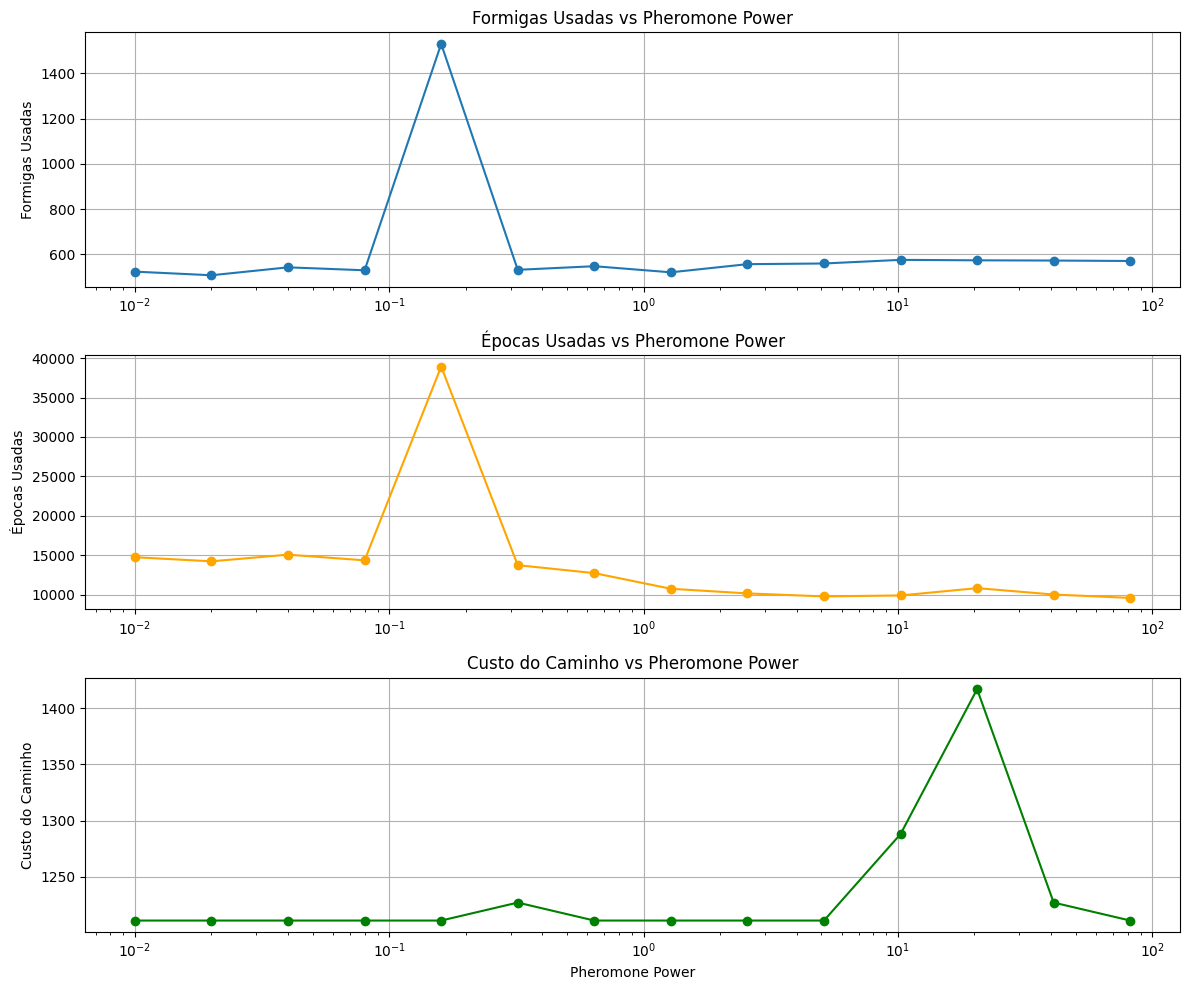

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Número de formigas usadas
plt.subplot(3, 1, 1)
plt.plot(pheromone_powers, ants_list, marker='o', linestyle='-')
plt.xscale('log')
plt.ylabel('Formigas Usadas')
plt.title('Formigas Usadas vs Pheromone Power')
plt.grid(True)

# Número de épocas usadas
plt.subplot(3, 1, 2)
plt.plot(pheromone_powers, epochs_list, marker='o', linestyle='-', color='orange')
plt.xscale('log')
plt.ylabel('Épocas Usadas')
plt.title('Épocas Usadas vs Pheromone Power')
plt.grid(True)

# Custo do caminho
plt.subplot(3, 1, 3)
plt.plot(pheromone_powers, path_cost_list, marker='o', linestyle='-', color='green')
plt.xscale('log')
plt.xlabel('Pheromone Power')
plt.ylabel('Custo do Caminho')
plt.title('Custo do Caminho vs Pheromone Power')
plt.grid(True)

plt.tight_layout()
plt.show()
